# Language Modeling using Ngram with NLTK

In this Exercise, you are going to use NLTK which is a natural language processing library for python to create a bigram language model and its variation. You will build one model for each of the following type and calculate their perplexity:
- Unigram Model
- Bigram Model
- Bigram Model with Laplace smoothing
- Bigram Model with Interpolation
- Bigram Model with Kneser-ney Interpolation



In [1]:
# #download corpus
!wget --no-check-certificate https://github.com/ekapolc/nlp_2019/raw/master/HW4/BEST2010.zip
!unzip BEST2010.zip

--2025-01-16 06:46:26--  https://github.com/ekapolc/nlp_2019/raw/master/HW4/BEST2010.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW4/BEST2010.zip [following]
--2025-01-16 06:46:26--  https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW4/BEST2010.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7423530 (7.1M) [application/zip]
Saving to: ‘BEST2010.zip’

BEST2010.zip        100%[===================>]   7.08M  --.-KB/s    in 0.1s    

2025-01-16 06:46:26 (51.5 MB/s) - ‘BEST2010.zip’ saved [7423530/7423530]

Archive:  BEST2010.zip
   creating: BEST2010/
  i

In [2]:
#Same set up
import math
import nltk
import io
import random
from random import shuffle
from collections import Counter, defaultdict
random.seed(999)

total_word_count = 0
best2010 = []
with open('BEST2010/news.txt','r',encoding='utf-8') as f:
  for i,line in enumerate(f):
    line=line.strip()[:-1] #remove the trailing |
    total_word_count += len(line.split("|"))
    best2010.append(line)

sentences = best2010
# The data is separated to train and test set with 70:30 ratio.
train = sentences[:int(len(sentences)*0.7)]
test = sentences[int(len(sentences)*0.7):]

First, we begin by creating a vocabulary.

In [3]:
from nltk.lm.preprocessing import pad_both_ends, flatten
from nltk.lm.vocabulary import Vocabulary

tokenized_train = [["<s>"] + t.split("|") + ["</s>"] for t in train] # "tokenize" each sentence
flat_tokens = list(flatten(tokenized_train)) #join all sentences into one long sentence
vocab = Vocabulary(flat_tokens, unk_cutoff=3) #Words with frequency **below** 3 (not exactly 3) will not be considered in our vocab and will be converted to <UNK>.

In [4]:
len(list(vocab)), list(vocab)[:5]

(9063, ['<s>', 'สงสัย', 'ติด', 'หวัด', 'นก'])

After we have a vocab, we have to deal with unknown tokens by replacing words not in vocab with \<UNK\>

In [5]:
tokenized_train = [[token if token in vocab else "<UNK>" for token in sentence] for sentence in tokenized_train]

Now we do the same for test data

In [6]:
tokenized_test = [t.split("|") for t in test]
tokenized_test = [[token if token in vocab else "<UNK>" for token in sentence] for sentence in tokenized_test]

# Unigram

In [7]:
from nltk.lm import MLE #Maximum likelihood estimator

In [8]:
from nltk import ngrams

In [9]:
train_unigrams = [list(ngrams(sent, n=1)) for sent in tokenized_train] #creating the unigrams by setting n=1

In [10]:
train_unigrams[0][:10]

[('<s>',),
 ('สงสัย',),
 ('ติด',),
 ('หวัด',),
 ('นก',),
 (' ',),
 ('อีก',),
 ('คน',),
 ('ยัง',),
 ('น่า',)]

In [11]:
lm = MLE(1) #order=1 for unigram
lm.fit(train_unigrams, vocab) #train the model
print("Perplexity of the unigram LM on the training set is", lm.perplexity(list(flatten(train_unigrams))))

Perplexity of the unigram LM on the training set is 448.8969075126217


In [12]:
test_unigrams = [list(ngrams(sent, n=1)) for sent in tokenized_test]

In [13]:
print("Perplexity of the unigram LM on the test set is", lm.perplexity(list(flatten(test_unigrams))))

Perplexity of the unigram LM on the test set is 392.7402896655927


We can inspect the probability of each word learned by the LM. There's also logscore and entropy to play around with. Feel free to try it out yourself.

In [14]:
print("Probability of '<UNK>':", lm.score('<UNK>'))

Probability of '<UNK>': 0.019213683523407844


We can also generate text! It won't be good though.

In [15]:
lm.generate(5, text_seed=["<s>"], random_seed=3)

['กล่าว', 'ประเทศ', 'จุดยืน', 'มา', 'มี']

# Bigram

In [16]:
train_bigrams = [list(ngrams(sent, n=2)) for sent in tokenized_train]

In [17]:
bigram_model = MLE(2)
bigram_model.fit(train_bigrams+train_unigrams, list(vocab)) #NLTK doesn't automatically learn lower order n-grams from higher order ones during training. you can also use padded_everygram_pipeline to automatically provide all n-grams to the model (ref: https://www.nltk.org/api/nltk.lm.html#nltk-language-modeling-module).
print("Perplexity of the bigram LM on the training set is", bigram_model.perplexity(list(flatten(train_bigrams))))

Perplexity of the bigram LM on the training set is 56.45504870235764


In case of bigram, we can provide a context

In [18]:
bigram_model.logscore("สงสัย", context=["<s>"])

-12.4039440401536

In [19]:
test_bigrams = [list(ngrams(sent, n=2)) for sent in tokenized_test]

In [20]:
bigram_model.perplexity(list(flatten(test_bigrams))) #what happened here?

inf

In [43]:
bigram_model.perplexity(list(flatten(test_bigrams))[:16]) #seems fine up until this bigram #15

24.59869160387618

In [44]:
bigram_model.perplexity(list(flatten(test_bigrams))[:17]) #bigram #16 is causing a problem

inf

In [45]:
list(flatten(test_bigrams))[16]

('แถลง', 'ยอด')

In [24]:
bigram_model.logscore("ยอด", context=["แถลง"]) #oops! an unseen bigram

-inf

In [25]:
bigram_model.perplexity([('แถลง', 'ยอด')]) #unfortunately, nltk doesnt handle the unseen bigram ('แถลง', 'ยอด') so the probability is 0 -> log(0) is undefined

inf

# Smoothing

Bigram with Laplace smoothing (Add-One Smoothing)

In [26]:
from nltk.lm import Laplace

In [27]:
laplace_lm = Laplace(order=2)

In [28]:
laplace_lm.fit(train_bigrams+train_unigrams, list(vocab)) #we can reuse the bigram+unigram data

In [29]:
print("Perplexity of the bigram LM with Laplace smoothing on the training set is", laplace_lm.perplexity(list(flatten(train_bigrams))))

Perplexity of the bigram LM with Laplace smoothing on the training set is 370.3095010878706


In [30]:
print("Perplexity of the bigram LM with Laplace smoothing on the test set is", laplace_lm.perplexity(list(flatten(test_bigrams))))

Perplexity of the bigram LM with Laplace smoothing on the test set is 369.1868035359409


# Bigram with Interpolation

There is no implementation of the one we showed in class in NLTK, so we will show you another model with a similar interpolation techinque.

The only difference is the Witten-Bell interpolation essentially finds the lambda through an equation (*don't worry about it, it won't be in the exam*) instead of letting us specify it.



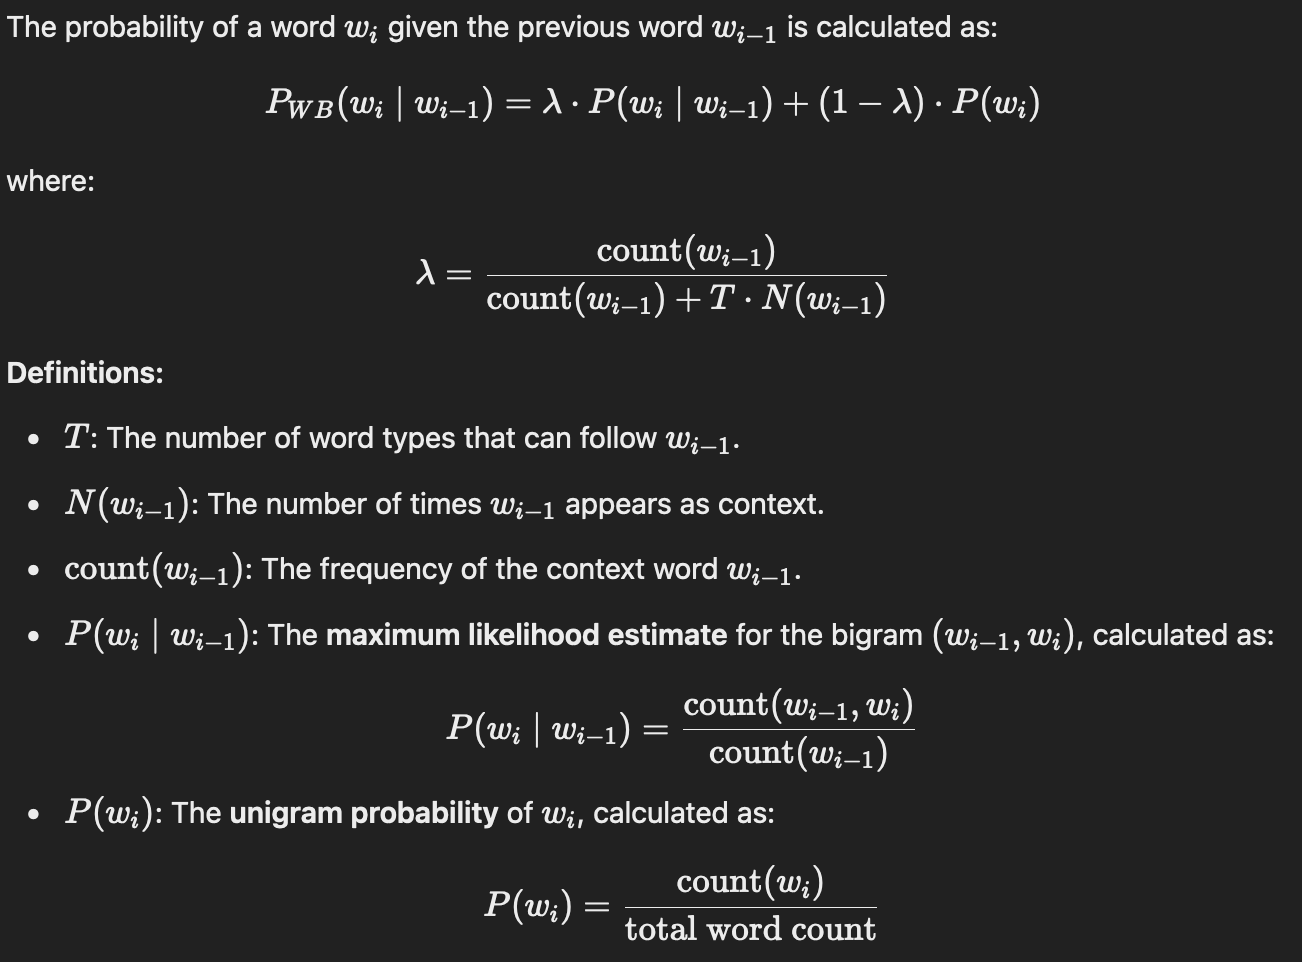

In [31]:
from nltk.lm import WittenBellInterpolated

In [32]:
interpolated = WittenBellInterpolated(order=2)

In [33]:
interpolated.fit(train_bigrams+train_unigrams, list(vocab))

In [34]:
print("Perplexity of the bigram LM with interpolation on the training set is", interpolated.perplexity(list(flatten(train_bigrams)))) # takes about 3.5 mins

Perplexity of the bigram LM with interpolation on the training set is 62.209835217912286


In [35]:
print("Perplexity of the bigram LM with interpolation on the test set is", interpolated.perplexity(list(flatten(test_bigrams))))

Perplexity of the bigram LM with interpolation on the test set is 97.3735729946882


# Kneser-ney




In [36]:
from nltk.lm.models import KneserNeyInterpolated

In [37]:
kn_lm = KneserNeyInterpolated(discount=0.75,order=2)

In [38]:
kn_lm.fit(train_bigrams+train_unigrams, list(vocab))

In [39]:
print("Perplexity of the bigram LM with Kneser-ney smoothing on the training set is", kn_lm.perplexity(list(flatten(train_bigrams))[:1000])) #took ~50 secs

Perplexity of the bigram LM with Kneser-ney smoothing on the training set is 50.40541747450037


In [40]:
#evaluating on the whole training set probably won't finish before colab times out
# print("Perplexity of the bigram LM with Kneser-ney smoothing on the training set is", kn_lm.perplexity(list(flatten(train_bigrams))))

In [41]:
print("Perplexity of the bigram LM with Kneser-ney smoothing on the test set is", kn_lm.perplexity(list(flatten(test_bigrams))[:1000])) #took ~50 secs

Perplexity of the bigram LM with Kneser-ney smoothing on the test set is 90.29909158711608


In [42]:
#this probably won't finish before colab times out either
# print("Perplexity of the bigram LM with Kneser-ney smoothing on the test set is", kn_lm.perplexity(list(flatten(test_bigrams))))